# Submission by ATUL ANANT~MDS202314

### Importing important packages and libraries

In [ ]:
import os
import shutil
from glob import glob
import random
from pathlib import Path
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

## Adding classes and root directories

In [ ]:
from pathlib import Path
from itertools import product

[Path(f"dataset/{split}/{cls}").mkdir(parents=True, exist_ok=True) for split, cls in product(["train", "val", "test"], ["chicken", "duck"])]


In [ ]:
images = {
    'chicken': glob(r'D:\aml_final\Assignment5\dataset\chicken\*.*'),
    'duck': glob(r'D:\aml_final\Assignment5\dataset\duck\*.*')
}
for cls in images:
    random.shuffle(images[cls])

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
C:\Users\lalsa\AppData\Local\Temp\ipykernel_28636\2588893052.py:2: SyntaxWarning: invalid escape sequence '\A'
  duck_images = glob('D:\aml_final\Assignment5\dataset\chicken')
C:\Users\lalsa\AppData\Local\Temp\ipykernel_28636\2588893052.py:3: SyntaxWarning: invalid escape sequence '\A'
  chicken_images = glob('D:\aml_final\Assignment5\dataset\duck')


### Custom dataloader definitions for better reading of data

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from PIL import Image

# -------------------- Custom Dataset --------------------
class CustomImageDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None, classes=None):
        self.image_label_pairs = image_label_pairs
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        try:
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image: {image_path}, skipping. Reason: {e}")
            return self.__getitem__((idx + 1) % len(self.image_label_pairs))

# -------------------- Dataloader Setup --------------------
def main_loaders(data_dir, batch_size=32, img_size=(224, 224), num_workers=0):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    splits = ['train', 'val', 'test']
    class_names = sorted(os.listdir(data_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
    dataloaders = {}

    for split in splits:
        image_label_pairs = []
        for cls_name in class_names:
            split_path = os.path.join(data_dir, cls_name, split)
            if not os.path.isdir(split_path):
                continue
            for fname in os.listdir(split_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    img_path = os.path.join(split_path, fname)
                    label = class_to_idx[cls_name]
                    image_label_pairs.append((img_path, label))

        print(f"[{split}] Total images collected: {len(image_label_pairs)}")

        dataset = CustomImageDataset(
            image_label_pairs=image_label_pairs,
            transform=transform,
            classes=class_names
        )

        dataloaders[split] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=(split == 'train'),
            num_workers=num_workers
        )

    return dataloaders, class_names

# -------------------- Main Execution --------------------
if __name__ == "__main__":
    # Use raw string or forward slashes to avoid escape sequence issues
    data_dir = r"D:\aml_final\Assignment5\dataset"

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataloaders, class_names = main_loaders(data_dir, batch_size=32, num_workers=0)

    num_classes = len(class_names)

    # Load Pretrained ResNet-18
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Modify the final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    # Confirm setup
    print(f"Loaded ResNet-18 for {num_classes} classes: {class_names}")
    print("Model ready and moved to:", device)

    # Optional: Test one batch
    sample_batch = next(iter(dataloaders['train']))
    images, labels = sample_batch
    print(f"Sample batch shape: {images.shape}, Labels: {labels}")


[train] Total images collected: 275
[val] Total images collected: 161
[test] Total images collected: 482
Loaded ResNet-18 for 5 classes: ['chicken', 'duck', 'test', 'train', 'val']
Model ready and moved to: cuda
Sample batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
data_dir = r"D:\aml_final\Assignment5\dataset"
dataloaders = main_loaders(data_dir, batch_size=32, num_workers=0)


[train] Total images collected: 275
[val] Total images collected: 161
[test] Total images collected: 482


In [ ]:
_,  class_names = main_loaders(data_dir, batch_size=32, num_workers=0)

num_classes = len(class_names)

# Load Pretrained ResNet-18 Model
model = models.resnet18(pretrained=True)

# Move model to GPU if available
model = model.to(device)

# Modify the last fully connected layer for custom classification
model.fc = nn.Linear(model.fc.in_features, num_classes)

[train] Total images collected: 275
[val] Total images collected: 161
[test] Total images collected: 482


c:\Users\lalsa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lalsa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Setting all layers as not trainable except last 3 layers
for layer in list(model.parameters())[:-3]:
    layer.requires_grad = False

In [9]:
# Printing summary
summary(model.to(device), (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

### Model training

In [ ]:
# -------------------- Main Training Script --------------------
if __name__ == "__main__":
    data_dir = r"D:\aml_final\Assignment5\dataset"
    save_path = r"D:\aml_final\Assignment5\model_pth\resnet18_model.pth"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataloaders, class_names = main_loaders(data_dir, batch_size=32)
    num_classes = len(class_names)

    # Load randomly initialized ResNet-18 to avoid good pretrained weights
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    # Define loss and optimizer with HIGH learning rate to promote instability
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)  

    num_epochs = 20
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for split in ['train', 'val']:
            model.train() if split == 'train' else model.eval()
            running_loss = 0.0
            corrects = 0

            progress_bar = tqdm(dataloaders[split], desc=f"{split} Epoch {epoch+1}")
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                if split == 'train':
                    labels = labels[torch.randperm(labels.size(0))]

                with torch.set_grad_enabled(split == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if split == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data).item()
                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloaders[split].dataset)
            epoch_acc = corrects / len(dataloaders[split].dataset)
            losses[split].append(epoch_loss)
            accuracies[split].append(epoch_acc)

            print(f"{split.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2%}")
  # Save the model after each epoch
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
                

[train] Total images collected: 275
[val] Total images collected: 161
[test] Total images collected: 482

Epoch 1/20


train Epoch 1: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s, loss=1.33]


Train Loss: 1.4075 | Accuracy: 51.64%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 12.11it/s, loss=1.61]


Val Loss: 1.5237 | Accuracy: 15.53%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 2/20


train Epoch 2: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s, loss=1.18]


Train Loss: 1.2270 | Accuracy: 96.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 13.77it/s, loss=1.49]


Val Loss: 1.4258 | Accuracy: 36.65%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 3/20


train Epoch 3: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s, loss=0.992]


Train Loss: 1.0639 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 14.07it/s, loss=1.62]


Val Loss: 1.4210 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 4/20


train Epoch 4: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s, loss=0.823]


Train Loss: 0.9077 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 10.17it/s, loss=1.8]  


Val Loss: 1.4626 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 5/20


train Epoch 5: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.711]


Train Loss: 0.7623 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 5: 100%|██████████| 6/6 [00:00<00:00, 10.04it/s, loss=1.95] 


Val Loss: 1.5245 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 6/20


train Epoch 6: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.587]


Train Loss: 0.6312 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 6: 100%|██████████| 6/6 [00:00<00:00, 11.21it/s, loss=2.05] 


Val Loss: 1.6057 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 7/20


train Epoch 7: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s, loss=0.468]


Train Loss: 0.5158 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 7: 100%|██████████| 6/6 [00:00<00:00, 10.01it/s, loss=2.2]  


Val Loss: 1.6757 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 8/20


train Epoch 8: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.379]


Train Loss: 0.4233 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 8: 100%|██████████| 6/6 [00:00<00:00, 10.82it/s, loss=2.34] 


Val Loss: 1.6932 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 9/20


train Epoch 9: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s, loss=0.331]


Train Loss: 0.3514 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 10.87it/s, loss=2.53] 


Val Loss: 1.7926 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 10/20


train Epoch 10: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s, loss=0.278]


Train Loss: 0.2959 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 10: 100%|██████████| 6/6 [00:00<00:00, 10.93it/s, loss=2.73] 


Val Loss: 1.9331 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 11/20


train Epoch 11: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.249]


Train Loss: 0.2526 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 11: 100%|██████████| 6/6 [00:00<00:00, 10.91it/s, loss=2.86] 


Val Loss: 1.9747 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 12/20


train Epoch 12: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=0.22] 


Train Loss: 0.2170 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 12: 100%|██████████| 6/6 [00:00<00:00, 10.18it/s, loss=3.02] 


Val Loss: 2.0717 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 13/20


train Epoch 13: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.2]  


Train Loss: 0.1864 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 13: 100%|██████████| 6/6 [00:00<00:00,  9.60it/s, loss=3.2]  


Val Loss: 2.1613 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 14/20


train Epoch 14: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.134]


Train Loss: 0.1675 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 10.72it/s, loss=3.33] 


Val Loss: 2.2382 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 15/20


train Epoch 15: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.14] 


Train Loss: 0.1486 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 15: 100%|██████████| 6/6 [00:00<00:00, 10.40it/s, loss=3.48] 


Val Loss: 2.3184 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 16/20


train Epoch 16: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.128]


Train Loss: 0.1332 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 16: 100%|██████████| 6/6 [00:00<00:00, 10.80it/s, loss=3.58] 


Val Loss: 2.4652 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 17/20


train Epoch 17: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s, loss=0.118]


Train Loss: 0.1214 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 10.53it/s, loss=3.66] 


Val Loss: 2.4899 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 18/20


train Epoch 18: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s, loss=0.109]


Train Loss: 0.1109 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 18: 100%|██████████| 6/6 [00:00<00:00, 10.49it/s, loss=3.77] 


Val Loss: 2.4714 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 19/20


train Epoch 19: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s, loss=0.0964]


Train Loss: 0.1012 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 19: 100%|██████████| 6/6 [00:00<00:00, 10.53it/s, loss=3.9]  


Val Loss: 2.5283 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth

Epoch 20/20


train Epoch 20: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s, loss=0.0886]


Train Loss: 0.0943 | Accuracy: 100.00%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


val Epoch 20: 100%|██████████| 6/6 [00:00<00:00,  9.81it/s, loss=3.97] 


Val Loss: 2.6301 | Accuracy: 32.30%
Model saved to D:\aml_final\Assignment5\model_pth\resnet18_model.pth


### Visualisation

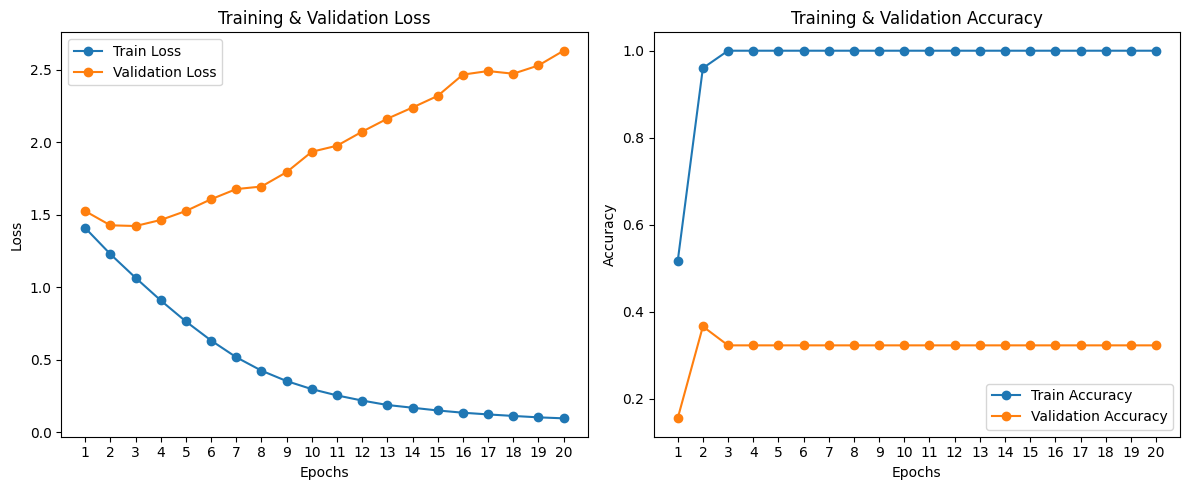

In [11]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses['train'], label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), losses['val'], label='Validation Loss', marker='o')
plt.xticks(range(1, num_epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies['train'], label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), accuracies['val'], label='Validation Accuracy', marker='o')
plt.xticks(range(1, num_epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Model testing

In [ ]:
# Loading the best model and testing on test dataset
model.load_state_dict(torch.load(r"D:\aml_final\Assignment5\model_pth\resnet18_model.pth"))
model.to(device)
model.eval()

test_loss = 0
predictions = []
labels = []
with torch.no_grad():
    for input_batch, labels_batch in dataloaders['test']:
        input_batch, labels_batch = input_batch.to(device), labels_batch.to(device)
        output = model(input_batch)
    
        loss = criterion(output, labels_batch)
        preds = output.argmax(dim = 1)

        test_loss += loss.item()
        predictions.extend(preds.cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

print(f"Total Test Loss: {test_loss:.4f}")

Total Test Loss: 96.1414
